## Analysing the experimental data of  [Brydges et al, Science 2019](https://doi.org/10.1126/science.aau4963)

In [1]:
using Revise
using RandomMeas
using ProgressMeter

In [2]:
## parameters 
N = 10 # System size
times = [0,1,2,3,4,5] # quench times in ms
ntimes = length(times)  # number of time points
ξ = siteinds("Qubit", N); # site indices of the shadows

# Parameters specifying the Renyi entropies of interest
n = 6 # maximal Renyi index (n-th Renyi entropy)
NAmax = 6; #maximal subsystem size. We always consider subsystems of the form [1,2,...,NA].

We now load the experimental randomized measurement data obtained in Brydges et al., Science 2018.

In [5]:
data = Vector{MeasurementData}(undef, ntimes)

for s in 1:ntimes
    data[s] = import_measurement_data("BrydgesScience2019data/measurement_data_10_T_" * string(times[s]) * ".npz",site_indices=ξ)
end 

We estimate the purity using the direct purity estimation formula presented Brydges et al., Science 2019 and using classical shadows Huang et al., Nat. Phys. 2020.

In [12]:
p_direct = zeros(Float64,ntimes,NAmax)
p_shadow = zeros(Float64,ntimes,NAmax)
@showprogress for s in 1:ntimes
    for NA in 1:NAmax
        #uA = [ut[1:NA] for ut in u[s]]
        p_direct[s,NA] = get_purity_direct(data[s],collect(1:NA))
        #p_shadow[s,NA] = get_purity_shadows(data[s,:,:,1:NA],uA,ξ[1:NA])
    end
end

(NM, N) = size(data) = (150, 1)
ξ = siteinds("Qubit", N) = Index{Int64}[(dim=2|id=897|"Qubit,Site,n=1")]


BoundsError: BoundsError: attempt to access 2-element Vector{Int64} at index [0]

We estimate higher order Renyi entropies (up to order n) using batch shadows (c.f. Rath et al., PRXQ 2023).

In [9]:
#Tr(rho^n) and Renyis from batch shadows
p_bshadow = zeros(Float64,ntimes,NAmax,n-1)
S_bshadow = zeros(Float64,ntimes,NAmax,n-1)
@showprogress for s in 1:ntimes
    for NA in 1:NAmax
        uA = [ut[1:NA] for ut in u[s]]
        ξA = ξ[1:NA]
        ρs = get_batch_shadows(data[s,:,:,1:NA],ξA,uA,n)
        p_bshadow[s,NA,:] = get_moments(ρs, ξA, collect(2:n))
        for nt in 2:n
            S_bshadow[s,NA,nt-1]= log2(p_bshadow[s,NA,nt-1])/(1-nt)
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:14


Finally, we load quantum states generated by classical simulations (master equation evolution) of the experiment, including a decoherence model. We compute Renyi entropies.

In [10]:
ρ = Vector{ITensor}()
p = zeros(Float64,ntimes,NAmax,n-1)
S = zeros(Float64,ntimes,NAmax,n-1)
SvN = zeros(Float64,ntimes,NAmax)
ITensors.disable_warn_order()

for s in 1:ntimes
    qstate = matread("BrydgesScience2019data/rho_10_XY_10_-1.00_0.00"*string(times[s])*"_1_1_1_flr_1.mat")["rho"]
    qstate = reshape(qstate,tuple((2*ones(Int,2*N))...))
    push!(ρ,ITensor(qstate,vcat(ξ',ξ)))
    for NA in 1:NAmax
        A = collect(1:NA)
        ρA = copy(ρ[s])
        for i in 1:N
            if !(i in A)
                ρA *= δ(ξ[i],ξ[i]') 
            end
        end
        for nt in 2:n
            p[s,NA,nt-1] = real(trace(power(ρA,nt),ξ[1:NA]))
            S[s,NA,nt-1]= log2(p[s,NA,nt-1])/(1-nt)
        end
    end
end

We plot the purity as a function of NA for the different times.

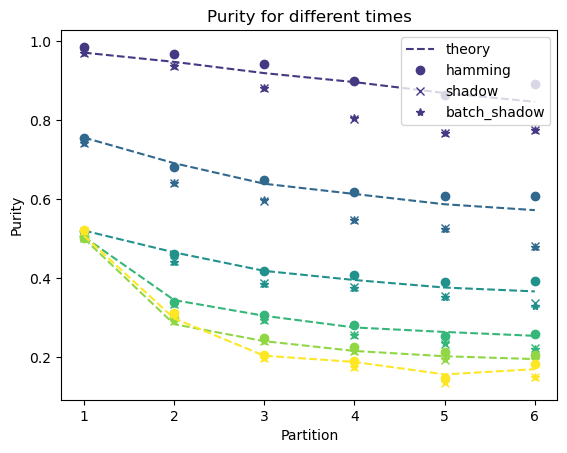

In [11]:
using PyPlot

clf()

cm = get_cmap(:viridis)
for s in 1:ntimes
    plot(1:NAmax,p[s,:,1],"--",color=cm(s/ntimes))
    plot(1:NAmax,p_direct[s,:],"o",color=cm(s/ntimes))
    plot(1:NAmax,p_shadow[s,:],"x",color=cm(s/ntimes))
    plot(1:NAmax,p_bshadow[s,:,1],"*",color=cm(s/ntimes))
end
#yscale("log")
xlabel("Partition")
ylabel("Purity")
legend(["theory","hamming","shadow","batch_shadow"])
title("Purity for different times")

gcf()

We plot the higher order Renyi entropies as a function of Renyi index n for a fixed subystem size and various times.

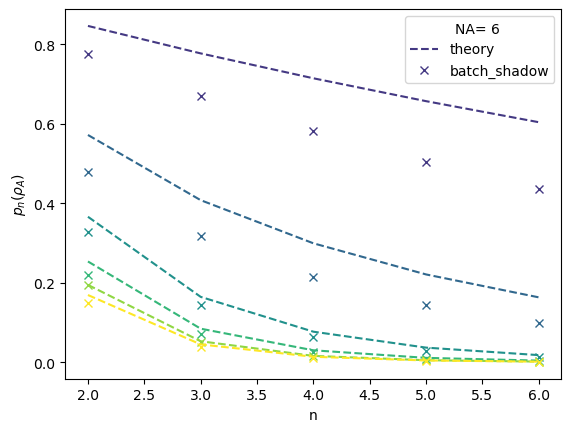

In [12]:
using PyPlot

clf()

NA = 6
for s in 1:1
    plot(2:n,p[s,NA,:],"--",color=cm(s/ntimes),label="theory")
    plot(2:n,p_bshadow[s,NA,:],"x",color=cm(s/ntimes),label="batch_shadow")
end
for s in 2:ntimes
    plot(2:n,p[s,NA,:],"--",color=cm(s/ntimes))
    plot(2:n,p_bshadow[s,NA,:],"x",color=cm(s/ntimes))
end
xlabel("n")
ylabel(L"p_n(\rho_A)")
legend(title = "NA= $NA ")

gcf()